# Türkiye Deprem Verileri ile Makine Öğrenmesi Projesi

# Proje Amacı

Son zamanlarda çevremizde de sıklıkla süregelen ve coğrafi konumumuz gereği kafamızı sürekli meşgul eden depremler hakkında daha düzgün sonuçlar ve daha iyi tahminler yapabiliriz umuduyla bu projeyi ele aldım.Bu projede 1999 yılından beri Türkiye'de meydana gelen depremlere ait geçmiş veriler kullanarak büyüklüğü 5.5 ve üzeri olan yıkıcı depremleri tahmin eden bir makine öğrenmesi modeli geliştirmeye çalıştım.

# Kullanılan Veri Seti
Kaynak: Türkiye Deprem Verileri(https://www.kaggle.com/datasets/yarenzoul/turkiye-deprem-verileri/data)
Satır Sayısı: 493.153
Sütun Sayısı: 21(Ön işlem sonrası)
Hedef Değişken(Label):'yikici'
'0': Yıkıcı olmayan deprem (`Magnitude < 5.5`)
'1': Yıkıcı deprem (`Magnitude ≥ 5.5`)
# Kullanılan Yöntemler
Keşifsel Veri Analizi (EDA)

Veri Ön İşleme

Veri Dengeleme

Gözetimli Öğrenme(Random Forest)

Model Değerlendirme

Sonuç

# Hedef
Geçmiş deprem verilerini analiz ederek, yeni veriler üzerinden yıkıcı deprem riski taşıyan olayları otomatik olarak sınıflandırabilen bir model inşa etmek.

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



In [135]:
#Veri setini yükleme
df = pd.read_csv('/kaggle/input/turkiye-deprem-verileri/data.csv')
df.head() #İlk 5 satırı görüntüle

,Date,Longitude,Latitude,Depth,Rms,Type,Magnitude,Location,EventID
0,27/04/2025 18:46:18,38.9378,38.3686,7.00,0.34,ML,2.2,Sivrice (Elazığ),659072
1,27/04/2025 18:44:45,38.8917,38.3883,7.42,0.25,ML,1.9,Sivrice (Elazığ),659071
2,27/04/2025 18:42:18,39.5172,38.5908,7.00,0.28,ML,1.1,Merkez (Elazığ),659070
3,27/04/2025 18:36:01,28.4603,40.8469,7.00,0.49,ML,1.6,Marmara Denizi - [17.61 km] Büyükçekmece (İsta...,659068
4,27/04/2025 18:35:21,38.9064,38.4014,7.00,0.36,ML,1.7,Sivrice (Elazığ),659069


# KEŞİFSEL VERİ ANALİZİ(EDA)
Bu bölümde "turkiye deprem verileri" veri setini daha yakından inceleyerek verinin genel yapısını,dağılımları ve değişkenler arasındaki ilişkilerini analiz ettim.Bu analizler modellemeden önce bu projenin kafamızda daha iyi yer etmesi ve verileri daha iyi anlamamız açısından kritik öneme sahip.

# Verinin Genel Yapısı
Satır,sütun sayıları. Kapladığı alan vs yer aldı bu bölümde. 

In [136]:
import os

#Dosya boyutunu öğrenelim
file_path = "/kaggle/input/turkiye-deprem-verileri/data.csv"
file_size_mb = os.path.getsize(file_path) / 1024**2
print(f"Veri seti boyutu: {file_size_mb:.2f} MB")


Veri seti boyutu: 42.44 MB


In [137]:
print("Satır × Sütun:", df.shape)
print("\nSütunlar:", df.columns.tolist())
print("\nVeri seti genel bilgisi:")
df.info()
print("\nSayısal sütun istatistikleri:")
df.describe()

Satır × Sütun: (493153, 9)

Sütunlar: ['Date', 'Longitude', 'Latitude', 'Depth', 'Rms', 'Type', 'Magnitude', 'Location', 'EventID']

Veri seti genel bilgisi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493153 entries, 0 to 493152
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date       493153 non-null  object 
 1   Longitude  493153 non-null  float64
 2   Latitude   493153 non-null  float64
 3   Depth      493153 non-null  float64
 4   Rms        493153 non-null  float64
 5   Type       493153 non-null  object 
 6   Magnitude  493153 non-null  float64
 7   Location   493153 non-null  object 
 8   EventID    493153 non-null  int64  
dtypes: float64(5), int64(1), object(3)
memory usage: 33.9+ MB

Sayısal sütun istatistikleri:


,Longitude,Latitude,Depth,Rms,Magnitude,EventID
count,493153.000000,493153.000000,493153.000000,493153.000000,493153.000000,493153.000000
mean,32.864796,38.468154,8.235176,0.408748,2.012571,370277.512103
std,5.450698,1.259243,5.683259,0.351539,0.705695,179379.551248
min,24.781000,33.547100,-0.034000,0.000000,0.000000,50516.000000
25%,27.870500,37.569000,6.990000,0.240000,1.400000,203655.000000
50%,30.900000,38.394000,7.000000,0.380000,1.900000,386526.000000
75%,37.764000,39.302000,7.110000,0.540000,2.600000,530428.000000
max,44.752300,43.758700,262.500000,82.800000,7.700000,659072.000000


In [138]:
df.shape      # Satır, sütun sayısı
df.columns    # Sütun isimleri
df.info()     # Veri tipleri, boş değerler
df.describe() # Sayısal sütunlara dair özet istatistikler


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493153 entries, 0 to 493152
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date       493153 non-null  object 
 1   Longitude  493153 non-null  float64
 2   Latitude   493153 non-null  float64
 3   Depth      493153 non-null  float64
 4   Rms        493153 non-null  float64
 5   Type       493153 non-null  object 
 6   Magnitude  493153 non-null  float64
 7   Location   493153 non-null  object 
 8   EventID    493153 non-null  int64  
dtypes: float64(5), int64(1), object(3)
memory usage: 33.9+ MB


,Longitude,Latitude,Depth,Rms,Magnitude,EventID
count,493153.000000,493153.000000,493153.000000,493153.000000,493153.000000,493153.000000
mean,32.864796,38.468154,8.235176,0.408748,2.012571,370277.512103
std,5.450698,1.259243,5.683259,0.351539,0.705695,179379.551248
min,24.781000,33.547100,-0.034000,0.000000,0.000000,50516.000000
25%,27.870500,37.569000,6.990000,0.240000,1.400000,203655.000000
50%,30.900000,38.394000,7.000000,0.380000,1.900000,386526.000000
75%,37.764000,39.302000,7.110000,0.540000,2.600000,530428.000000
max,44.752300,43.758700,262.500000,82.800000,7.700000,659072.000000


# Coğrafi Dağılım
Depremlerin Türkiye üzerindeki dağılımını görselleştirmek için enlem (Latitude) ve boylam (Longitude) bilgilerini kullandım. Depremleri büyüklüklerine göre renklendirip boyutlandırarak, özellikle yoğunluk ve büyüklük açısından dikkat çeken bölgeleri ortaya çıkardım.

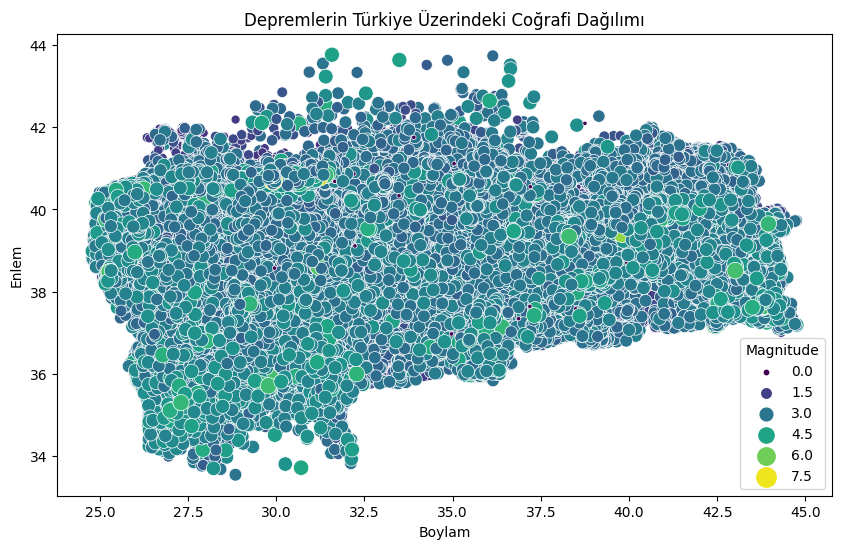

In [139]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Longitude', y='Latitude', hue='Magnitude', size='Magnitude', sizes=(10, 200), data=df, palette='viridis')
plt.title("Depremlerin Türkiye Üzerindeki Coğrafi Dağılımı")
plt.xlabel("Boylam")
plt.ylabel("Enlem")
plt.show()


In [140]:
#Depremlerin büyüklüğü için ortalama, medyan ve standart sapma
print("Magnitude(Deprem Büyüklüğü)")
print("Ortalama:", df['Magnitude'].mean())
print("Medyan:", df['Magnitude'].median())
print("Standart Sapma:", df['Magnitude'].std())
print()

#Depremlerin derinliği için ortalama, medyan ve standart sapma
print("Depth(Deprem Derinliği)")
print("Ortalama:", df['Depth'].mean())
print("Medyan:", df['Depth'].median())
print("Standart Sapma:", df['Depth'].std())


Magnitude(Deprem Büyüklüğü)
Ortalama: 2.0125705409882935
Medyan: 1.9
Standart Sapma: 0.7056948813196936

Depth(Deprem Derinliği)
Ortalama: 8.235176085312267
Medyan: 7.0
Standart Sapma: 5.6832590537906515


# Bu istatistiksel analizlerle ;
Ortalama vs. Medyan karşılaştırması ---Aykırı değer var mı?
(Örneğin Depth için çok yüksek değerler varsa ortalama yukarı çekilmiş olabilir.)
Standart sapma ---Değişkenin dağılımının ne kadar yaygın olduğunu gösterir.

# Aykırı Gözlem Analizi
Bazı depremler olağan dışı büyüklük ve derinlik değerlerine sahip olabilir.

Kartiller, sıralı bir veri setini dört eşit parçaya bölen değerlerdir:

Q1: 1. çeyrek (%25)
Q2: Medyan (%50) 
Q3: 3. çeyrek (%75) 
Bu kartiller sayesinde dağılımın merkezini ve yayılımını daha iyi anlayabiliriz. IQR, kartil aralığıdır Aykırı değerleri tespit etmek için şu sınırlar kullanılır: Alt sınır: Q1 - 1.5 × IQR Üst sınır: Q3 + 1.5 × IQR Bu aralığın dışına çıkan gözlemler aykırı kabul edilir.

In [141]:
#Kartiller
Q1 = df['Magnitude'].quantile(0.25) #1.çeyrek
Q2 = df['Magnitude'].quantile(0.50) #2.çeyrek 
Q3 = df['Magnitude'].quantile(0.75) #3.çeyrek
IQR = Q3 - Q1 #Çeyrekler arası aralık 

print("1. Çeyrek (Q1):", Q1)
print("2. Çeyrek (Medyan - Q2):", Q2)
print("3. Çeyrek (Q3):", Q3)
print("IQR (Q3 - Q1):", IQR)

#Aykırı değer sınırları
alt_sinir = Q1 - 1.5 * IQR
ust_sinir = Q3 + 1.5 * IQR

print("\nAlt sınır (outlier):", alt_sinir)
print("Üst sınır (outlier):", ust_sinir)

#Aykırı değer sayısı
outliers = df[(df['Magnitude'] < alt_sinir) | (df['Magnitude'] > ust_sinir)]
print("Aykırı değer sayısı:", len(outliers))

1. Çeyrek (Q1): 1.4
2. Çeyrek (Medyan - Q2): 1.9
3. Çeyrek (Q3): 2.6
IQR (Q3 - Q1): 1.2000000000000002

Alt sınır (outlier): -0.40000000000000036
Üst sınır (outlier): 4.4
Aykırı değer sayısı: 1008


# BURADA;
Magnitude değişkeninin çeyrek değerlerini ve IQR’ını kullanarak aykırı değer analizini gerçekleştirdim. IQR yöntemiyle belirlenen alt ve üst sınırlar dışında kalan kaç örnek olduğunu tespit ettim. Bu sayede veri setindeki potansiyel aykırı büyüklükteki depremleri gözlemleme şansı elde ettim.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


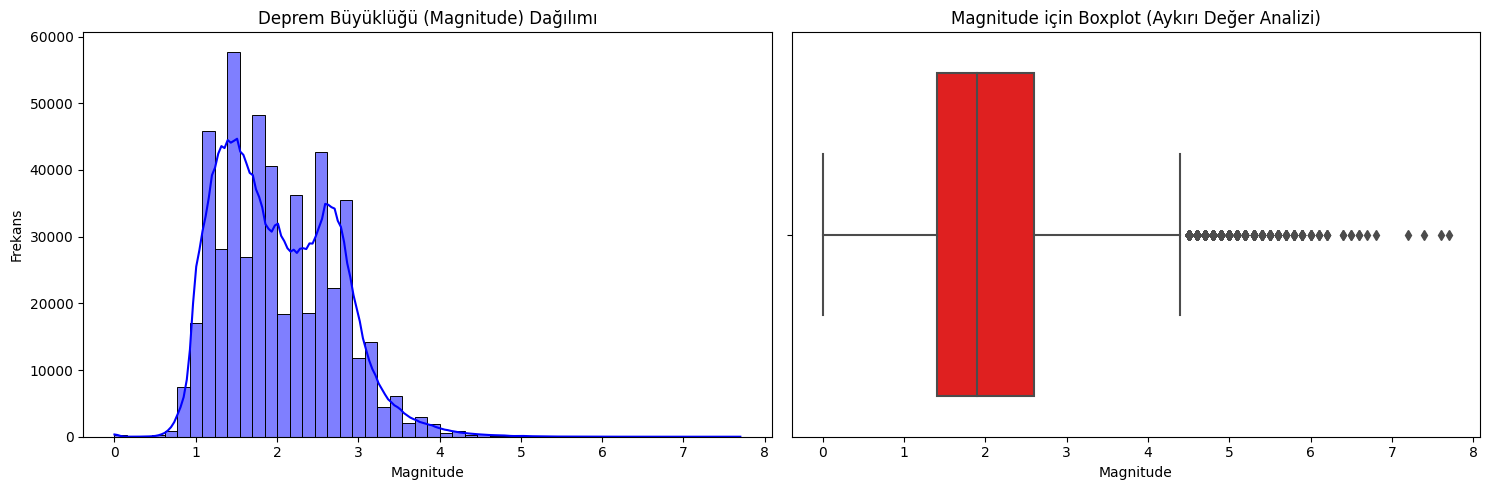

In [142]:
plt.figure(figsize=(15, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df['Magnitude'], bins=50, kde=True, color='blue')
plt.title('Deprem Büyüklüğü (Magnitude) Dağılımı')
plt.xlabel('Magnitude')
plt.ylabel('Frekans')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df['Magnitude'], color='red')
plt.title('Magnitude için Boxplot (Aykırı Değer Analizi)')
plt.xlabel('Magnitude')

plt.tight_layout()
plt.show()


# Bu Grafikler;
Histogramda çoğu depremin 2 ile 4 büyüklüğü arasında yoğunlaştığını, 5.5 üzeri yıkıcı depremlerin ise az sayıda gerçekleştiğini görüyoruz. Boxplot grafiğinde ise bu büyük değerlerin aykırı değer olarak sınıflandığını gözlemleyebiliyoruz. Bu grafikler veri dağılımını sezgisel olarak anlamamda önemli rol oynadı.


# Aykırı Değerleri Ortalama ile Doldurmak
Aykırı değerler, veri setinin ortalamasını, varyansını ve model başarımını olumsuz etkileyebilir. Bu nedenle, tespit ettiğimiz aykırı değerleri ilgili sütunun ortalama değeriyle değiştirerek yumuşatma uyguladım. Bu sayede veri kaybı yaşanmazken uç değerlerin dağılım üzerindeki etkisi azaltılmış oldu.


In [143]:
mean_val = df['Magnitude'].mean()

# Aykırı olanları ortalama ile değiştir
df_mean = df.copy()
df_mean.loc[df_mean['Magnitude'] < alt_sinir, 'Magnitude'] = mean_val
df_mean.loc[df_mean['Magnitude'] > ust_sinir, 'Magnitude'] = mean_val


# Örneklem
Tüm veri seti çok büyük olduğunda genel özellikleri test etmek için belirli bir yüzde ile örnek alabiliriz.

In [144]:
# Veri setinden rastgele %1 oranında örnek aldım mesela (yaklaşık 5000 satır)
ornek_df = df.sample(frac=0.01, random_state=42)

print("Örneklem veri boyutu:", ornek_df.shape)
ornek_df.head()

Örneklem veri boyutu: (4932, 9)


,Date,Longitude,Latitude,Depth,Rms,Type,Magnitude,Location,EventID
6907,28/01/2025 17:50:09,27.5081,40.4753,7.17,0.36,ML,1.5,Marmara Denizi - [02.91 km] Marmara (Balıkesir),650159
426474,17/04/2010 14:23:45,37.3378,40.5165,3.38,0.84,Md,3.0,Reşadiye (Tokat),102831
133654,14/01/2022 19:32:28,29.3536,37.3616,7.00,0.46,ML,1.3,Acıpayam (Denizli),519237
35310,22/02/2024 10:09:15,32.0094,36.6197,7.00,0.45,ML,1.0,Alanya (Antalya),620676
319908,02/09/2014 13:43:54,28.4485,36.9541,7.04,0.24,ML,1.4,Ula (Muğla),271900


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


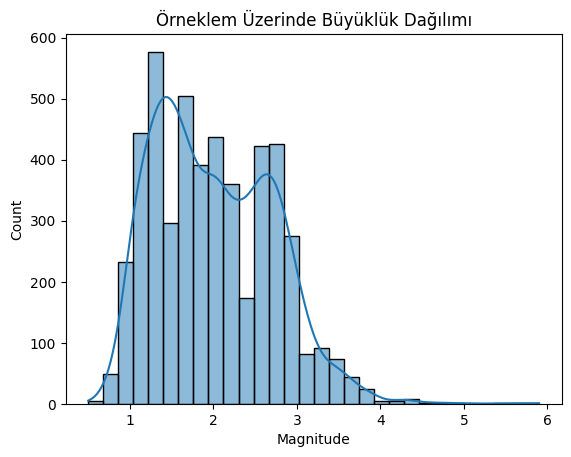

In [145]:
sns.histplot(ornek_df['Magnitude'], bins=30, kde=True)
plt.title("Örneklem Üzerinde Büyüklük Dağılımı")
plt.show()


In [146]:
#Standart Sapma
std_magnitude = df['Magnitude'].std()

print("Büyüklük (Magnitude) için Standart Sapma:", round(std_magnitude, 4))


Büyüklük (Magnitude) için Standart Sapma: 0.7057


In [147]:
#Varyans
var_magnitude = df['Magnitude'].var()

print(" Büyüklük (Magnitude) için Varyans:", round(var_magnitude, 4))


 Büyüklük (Magnitude) için Varyans: 0.498


In [148]:
#Çarpıklık
from scipy.stats import skew

skew_magnitude = skew(df['Magnitude'])

print("Büyüklük (Magnitude) için Çarpıklık (Skewness):", round(skew_magnitude, 4))


Büyüklük (Magnitude) için Çarpıklık (Skewness): 0.5173


In [149]:
#Basıklık
from scipy.stats import kurtosis

kurt_magnitude = kurtosis(df['Magnitude'])  # Excess kurtosis (normal dağılım için 0)
print("Büyüklük (Magnitude) için Basıklık (Kurtosis):", round(kurt_magnitude, 4))


Büyüklük (Magnitude) için Basıklık (Kurtosis): -0.0359


# Çarpıklık ve Basıklıkla;
Çarpıklık (Skewness) değeri 0.5173 olarak bulundu. Bu pozitif çarpıklık, büyüklük değişkeninin sağa çarpık olduğunu göstermektedir yani küçük büyüklükteki depremler daha sık görülürken, büyük depremler daha nadir ama mevcuttur.

Basıklık (Kurtosis) değeri ise -0.0359'dur. Bu değer normal dağılıma oldukça yakın bir basıklık gösterir. Yani dağılım, aykırı değerler açısından ne aşırı sivri ne de düz bir yapıdadır.


# Eksik Veri Analizi
Veri setinde eksik veri olup olmadığı kontrol ettim. Eksik veriler sorunlara yol açabileceğinden dolayı önce tespit edilmeli.

In [150]:
df.isnull().sum()       # Eksik değer sayısı

Date         0
Longitude    0
Latitude     0
Depth        0
Rms          0
Type         0
Magnitude    0
Location     0
EventID      0
dtype: int64

<Axes: >

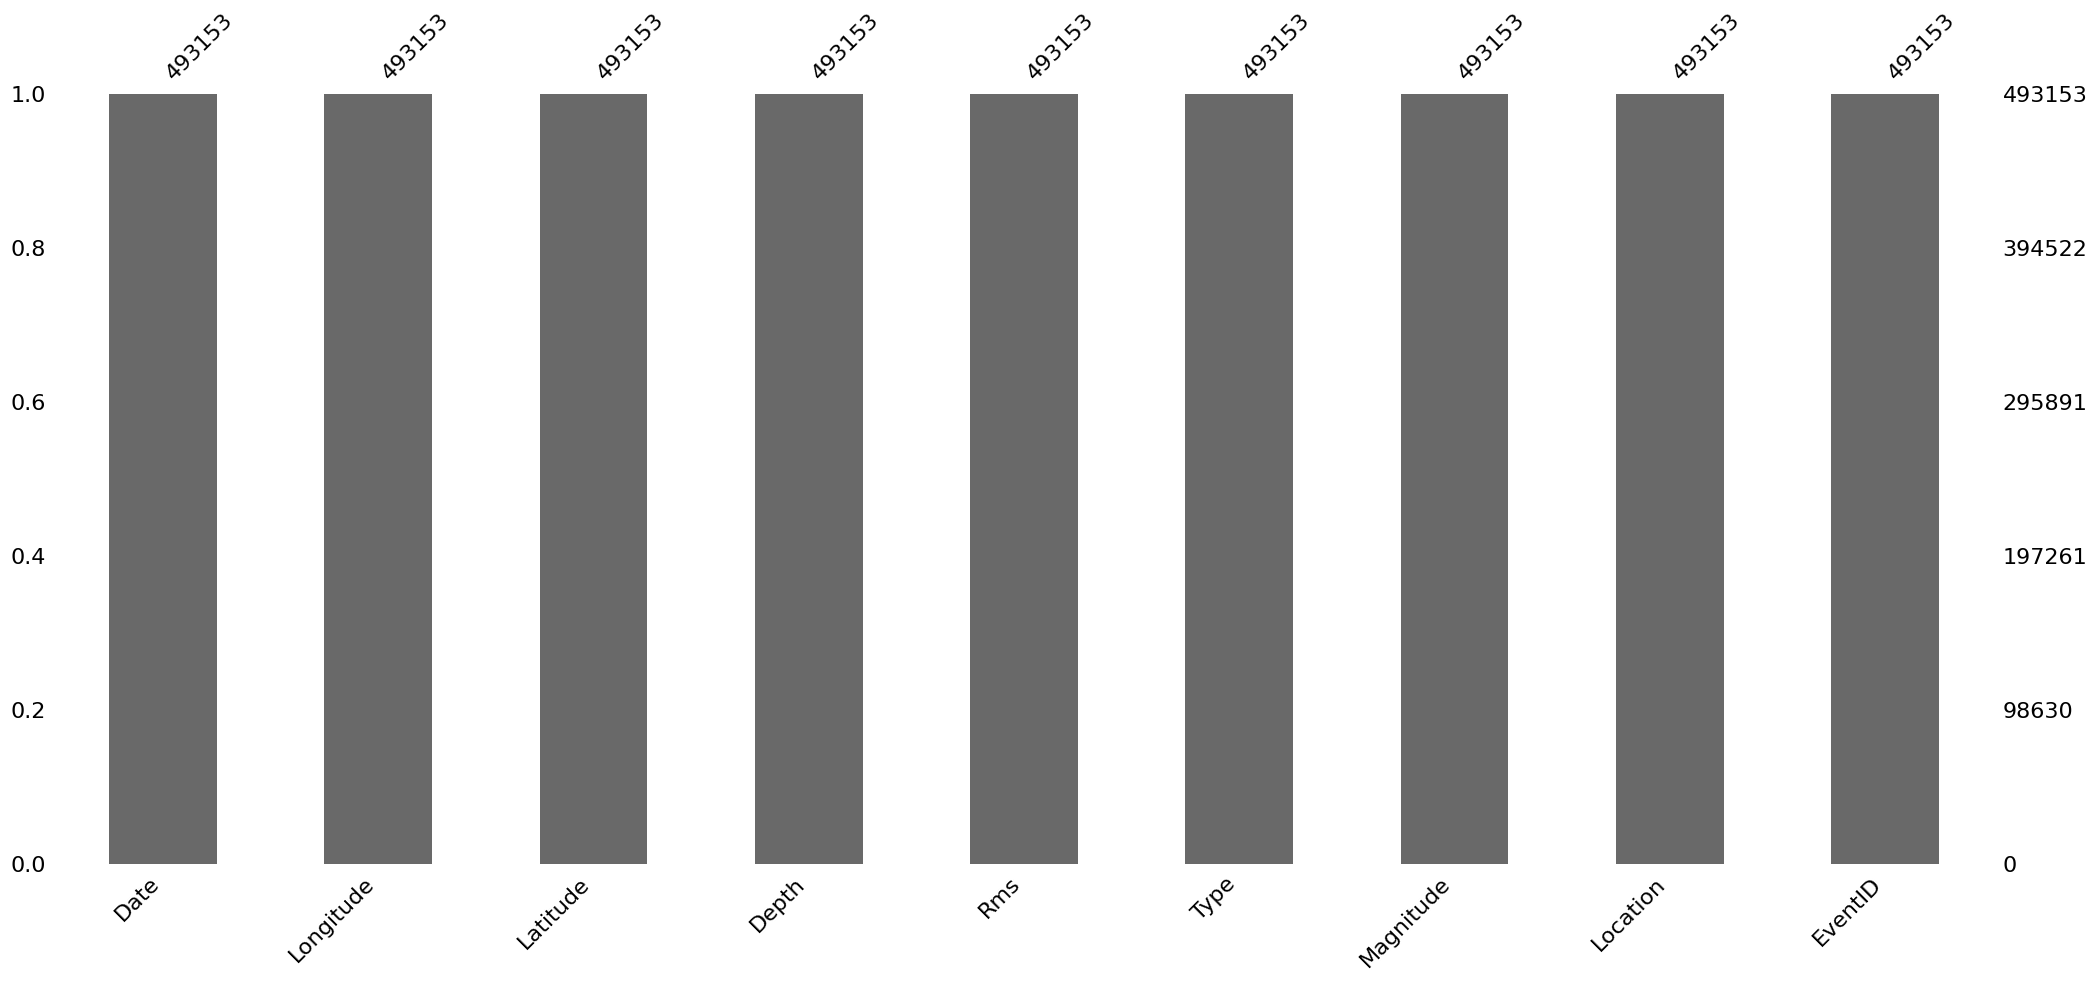

In [151]:
import missingno as msno
msno.bar(df) #veri setindeki değişkenlerin nan değer oranlarını bar grafiği olarak gösterir

# BAR GRAFİĞİ
Tüm sütunlar yaklaşık 493.153 değere sahip.

Grafikte tüm sütunlar eşit yükseklikte ve tamamen dolu olarak gözüküyor.

Bu durum veri setinde eksik veri olmadığını gösteriyor.

<Axes: >

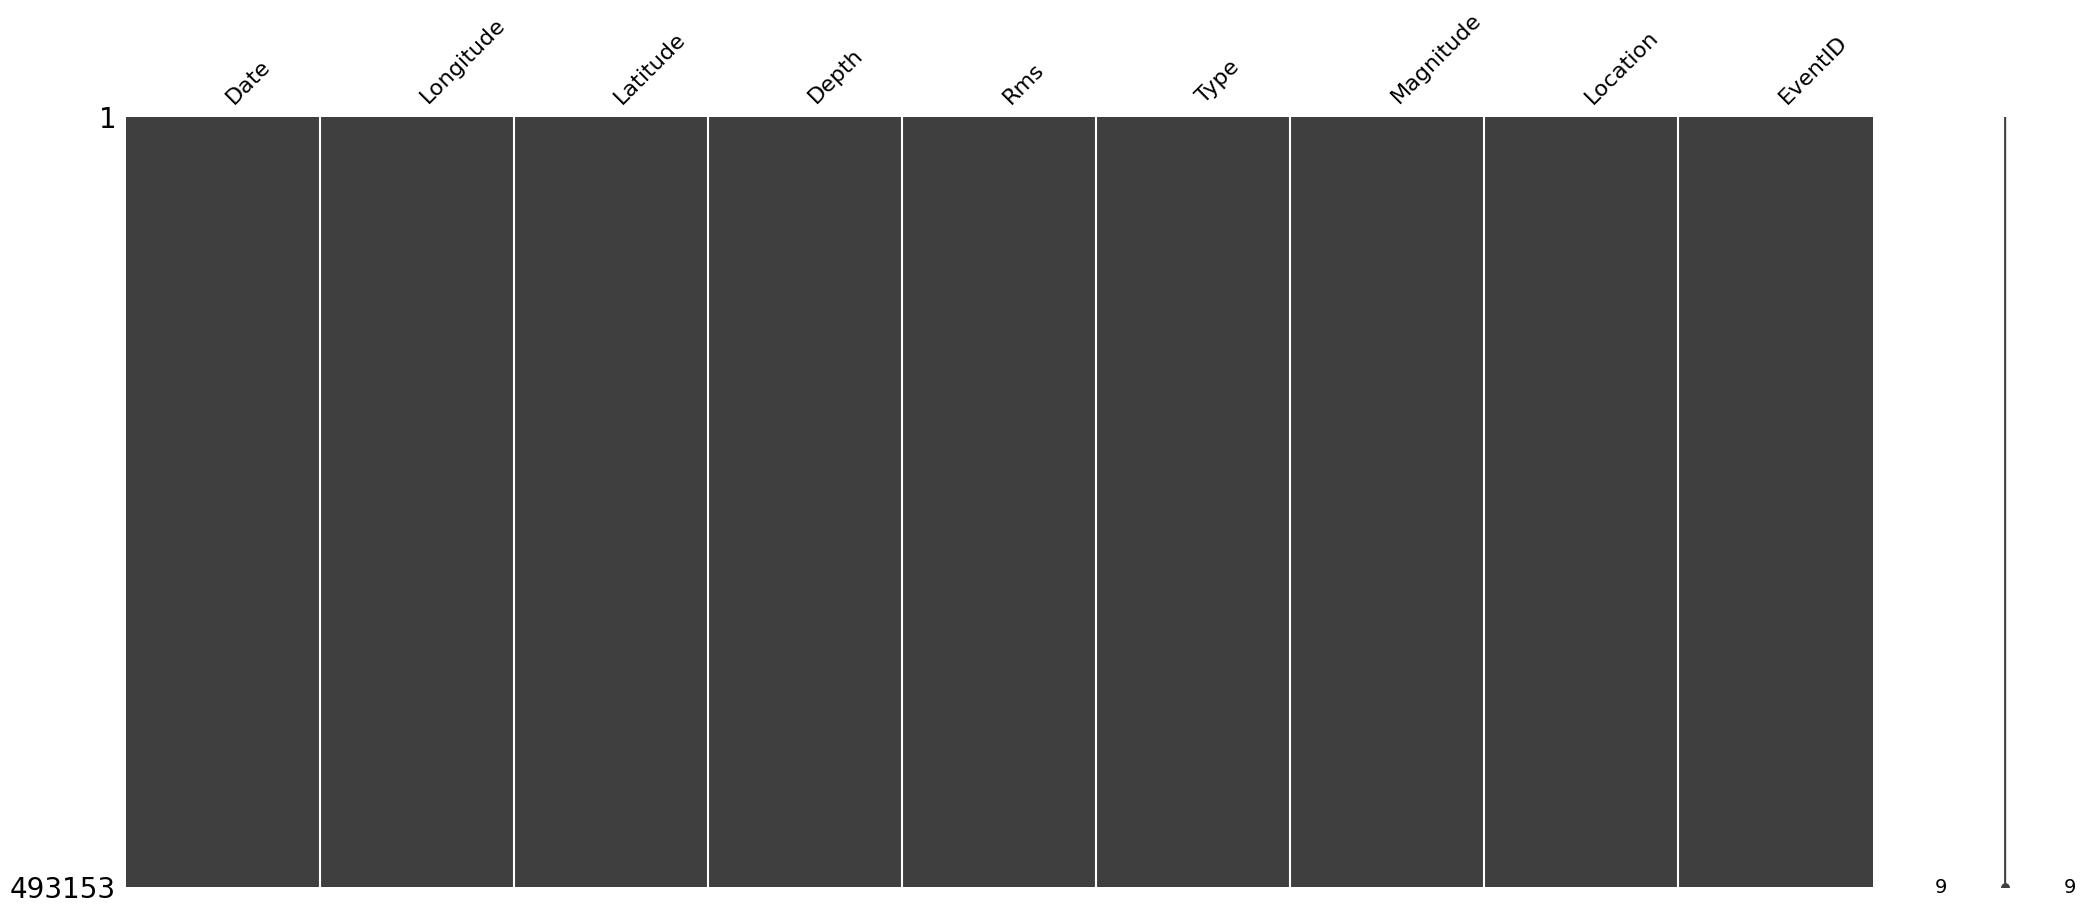

In [152]:
msno.matrix(df) #veri setindeki değişkenlerin hangi satırlarda nan olduğunu gösterir

# MATRİS GRAFİĞİ
Tüm sütunlarda siyah çizgiler kesintisiz şekilde devam ediyor.

Eksik gözlem olmadığı matris yapısından da doğrulanmış oluyor.

Beyaz boşluklar olsaydı bunlar eksik veri anlamına gelirdi ancak görünmüyor.

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


<Axes: >

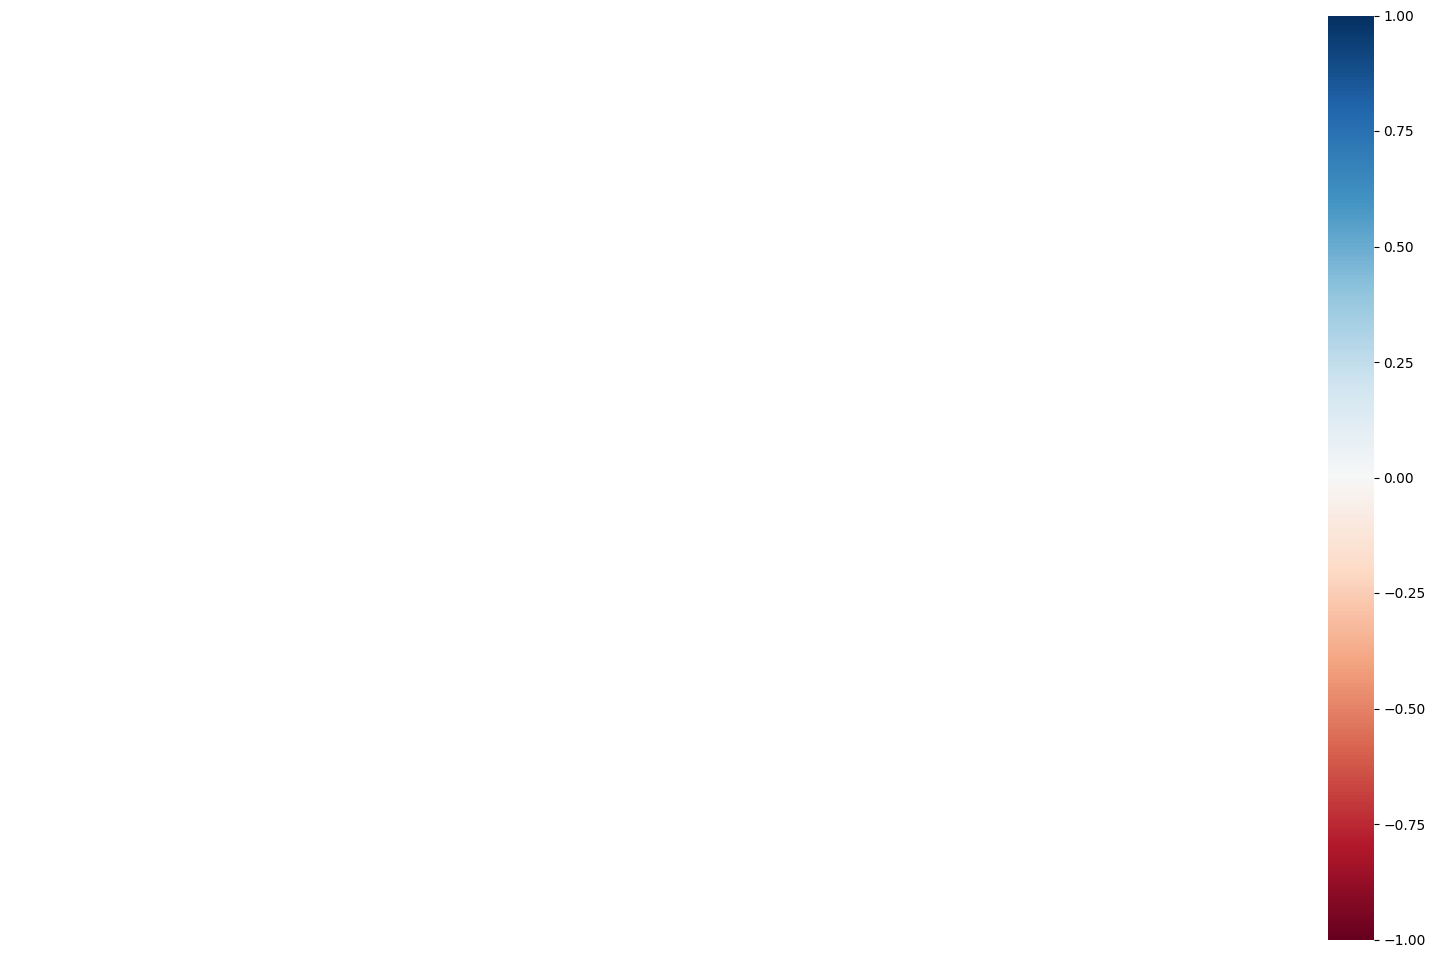

In [153]:
msno.heatmap(df) #Eksik verilerin korelasyonuna bakar, veri setindeki eksik değer örüntülerini analiz eder

# ISI HARİTASI
Isı haritası sütunlar arası eksik veri korelasyonunu gösterir.

Tüm korelasyonlar +1 olduğundan veri setinde eksik veri bulunmadığı net şekilde anlaşılır.

Yani herhangi iki değişkenin birlikte eksik olma ihtimali yok.



# Sayısal Değişkenlerin Dağılımı
Burada deprem büyüklüğü(magnitude) ve derinlik(depth) değişkenlerini inceledim.
seaborn kütüphanesinin histplot fonksiyonu ile histogramlar oluşturup Kernel Yoğunluk Tahmini (KDE) eğrileri ekledim.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


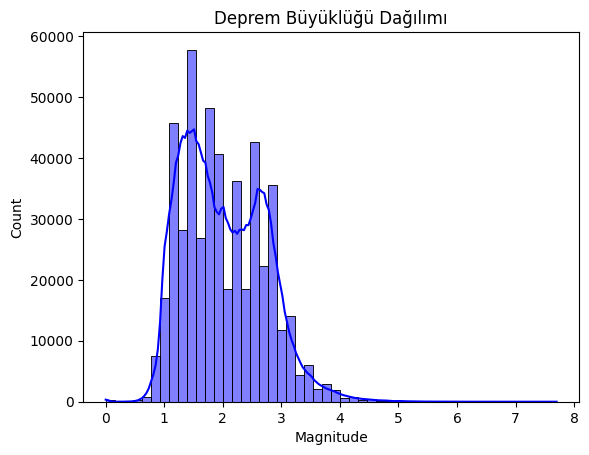

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


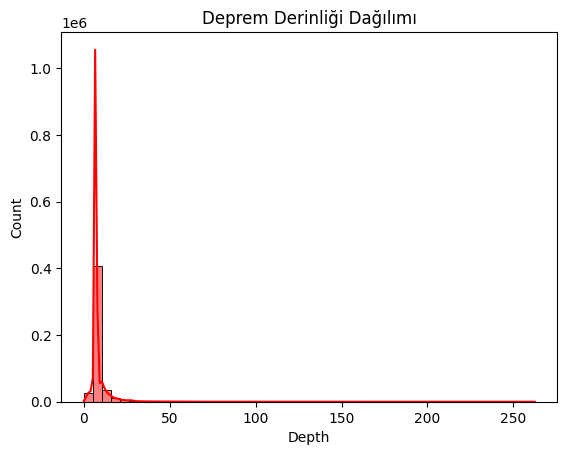

In [154]:
sns.histplot(df['Magnitude'], bins=50,color="blue", kde=True)
plt.title("Deprem Büyüklüğü Dağılımı")
plt.show()

sns.histplot(df['Depth'], bins=50, color="red", kde=True)
plt.title("Deprem Derinliği Dağılımı")
plt.show()

# GRAFİKLERİN ANALİZİ;
# Deprem Büyüklüğü Dağılımı
Grafikte deprem büyüklüklerinin histogramı ve KDE (yoğunluk tahmin eğrisi) gösterilmiştir.

En sık karşılaşılan deprem büyüklükleri 1 ile 3 arasında yoğunlaşmıştır.

2 civarında oldukça yüksek sayıda deprem meydana gelmiştir.

4 ve üzeri büyüklükteki depremler oldukça az sayıda gözlemlenmiştir.

Grafik, küçük büyüklükteki depremlerin doğada daha yaygın olduğunu ortaya koymaktadır.

# Deprem Derinliği Dağılımı
Derinlik histogramı ve KDE grafiği incelendiğinde, depremlerin büyük çoğunluğu yüzeye yakın (özellikle 0-10 km aralığında) gerçekleşmiştir.

Yaklaşık 5-10 km aralığı en yüksek yoğunluğa sahiptir.

Daha derinlerde gerçekleşen depremlerin sayısı dramatik biçimde azalmaktadır.

Bu dağılım, yeryüzüne yakın fay hatlarının daha aktif olduğunu göstermektedir.



# Korelasyon Analizi
Bu bölümde, sayısal değişkenler olan Latitude, Longitude, Depth ve Magnitude arasındaki ilişkilere baktım. Değişkenlerin birbiriyle olan korelasyonlarını anlamak, modelleme aşamasında bize önemli ipuçları verir.
Özellikle bazı değişkenler arasında güçlü pozitif veya negatif korelasyonlar varsa, bu durum modelin performansını etkileyebilir. Bu yüzden korelasyon matrisi oluşturarak bu ilişkileri görselleştirdim. Aşağıdaki ısı haritası, değişkenler arası ilişkileri daha net görmemi sağladı.

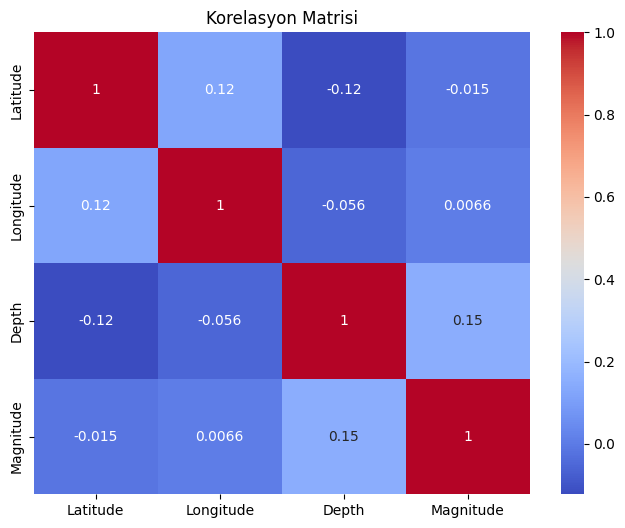

In [155]:
plt.figure(figsize=(8, 6))
corr = df[['Latitude', 'Longitude', 'Depth', 'Magnitude']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Korelasyon Matrisi")
plt.show()

# HEATMAP HAKKINDA;
+1'e yakın değerler → güçlü pozitif ilişki (örneğin iki değişken birlikte artıyor)

-1'e yakın değerler → güçlü negatif ilişki (biri artarken diğeri azalıyor)

0 civarı → ilişki zayıf ya da yok

# VERİ ÖN İŞLEME
Bu aşamada, deprem verimizi analiz ve modellemeye hazırlamak için çeşitli veri ön işleme adımları gerçekleştirdim.



# Sayısal Değişkenlerin Standartlaştırılması ve PCA
Öncelikle Latitude, Longitude, Depth ve Magnitude sayısal sütunlarını seçtim.

Bu sütunları StandardScaler ile standartlaştırdım (ortalama 0, standart sapma 1 olacak şekilde).

Verinin boyutunu düşürmek ve görselleştirmeyi kolaylaştırmak için PCA (Başlıca Bileşen Analizi) uygulayarak 2 bileşene indirdim.

PCA sonuçlarını yeni bir DataFrame olarak kaydettim.

In [156]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Sayısal sütunları seçtim
X = df[['Latitude', 'Longitude', 'Depth', 'Magnitude']]

# Veriyi standartlaştırdım
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA uyguladım (2 bileşene indirdim)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# PCA sonuçlarını yeni DataFrame'e ekledim
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca.head()


,PC1,PC2
0,-0.436697,0.716673
1,-0.567939,0.460973
2,-1.204922,-0.175234
3,-1.064003,-0.165377
4,-0.734576,0.258960


# Kategorileri Gruplama
Veri setindeki bazı sütunlar çok fazla kategori içerdiği için anlamlı ve sade hale getirmek amacıyla bazı gruplamalar yaptım:
Location sütunundaki şehir isimlerini Türkiye’nin 7 coğrafi bölgesine indirgedim (Doğu Anadolu, Marmara, vs.). Bu sayede hem bölgesel analiz yapılabilir hem de kategori sayısı azaltılmış olur.
Magnitude değişkenini daha sonra küçük, orta ve yüksek şeklinde sınıflandıracağım.
Type sütununda çok nadir görülen türler 'Other' adı altında gruplandırılarak sadeleştirilecek.

In [157]:
def bolge_belirle(loc):
    loc = str(loc)
    if "Elazığ" in loc or "Malatya" in loc or "Adıyaman" in loc:
        return "Doğu Anadolu"
    elif "İstanbul" in loc or "Kocaeli" in loc or "Bursa" in loc:
        return "Marmara"
    elif "Ankara" in loc or "Konya" in loc or "Kayseri" in loc:
        return "İç Anadolu"
    elif "Trabzon" in loc or "Rize" in loc or "Giresun" in loc:
        return "Karadeniz"
    elif "İzmir" in loc or "Muğla" in loc or "Aydın" in loc:
        return "Ege"
    elif "Antalya" in loc or "Mersin" in loc or "Adana" in loc:
        return "Akdeniz"
    else:
        return "Diğer"

df['Bolge'] = df['Location'].apply(bolge_belirle)

# Bölge dağılımı
df['Bolge'].value_counts()


Bolge
Diğer           266144
Ege             112199
Doğu Anadolu     59600
Akdeniz          23586
İç Anadolu       20408
Marmara           9164
Karadeniz         2052
Name: count, dtype: int64

# Deprem Büyüklüklerinin Kategorize Edilmesi
Deprem büyüklüklerini, anlamlı kategoriler oluşturacak şekilde sınıflandırdım:

4.0'dan küçükse "Küçük"

4.0 ile 5.5 arası ise "Orta"

5.5 ve üzeriyse "Yüksek"

Yeni bir sütun olarak MagnitudeKategori'yi ekledim.


In [158]:
def magnitude_kategorize(m):
    if m < 4.0:
        return "Küçük"
    elif m < 5.5:
        return "Orta"
    else:
        return "Yüksek"

df['MagnitudeKategori'] = df['Magnitude'].apply(magnitude_kategorize)

# Dağılım
df['MagnitudeKategori'].value_counts()


MagnitudeKategori
Küçük     489587
Orta        3489
Yüksek        77
Name: count, dtype: int64

# Deprem Tiplerinin Sadeleştirilmesi
En sık görülen 3 deprem tipi dışındaki tipleri “Other” olarak etiketledim.

Böylece sınıf sayısını azaltıp modelleme için daha sade bir yapı oluşturdum.

In [159]:
# En sık görülen ilk 3 tipi tutup diğerlerini "Other" olarak etiketledim
common_types = df['Type'].value_counts().nlargest(3).index

df['Type_Sade'] = df['Type'].apply(lambda x: x if x in common_types else "Other")

# Yeni type sütunu dağılımı
df['Type_Sade'].value_counts()

Type_Sade
ML       330172
Md        99994
Ml        57509
Other      5478
Name: count, dtype: int64

# Logaritmik Dönüşüm ve Standartlaştırma
Depth sütununa log(1+x) dönüşümü uygulayarak derinlik dağılımını normalize ettim.

Latitude, Longitude, Magnitude ve Depth_log sütunlarını StandardScaler ile z-score standardizasyonuna tabi tuttum.

Böylece veriler, modellemeye daha uygun hale geldi.


In [160]:
# Kopya dataframe oluşturma
df_transformed = df.copy()

# Depth değişkenine log(1+x) dönüşümü uygulama
df_transformed['Depth_log'] = np.log1p(df_transformed['Depth'])

# StandardScaler ile z-score standardizasyonu uygulama
scaler = StandardScaler()
df_transformed[['Latitude', 'Longitude', 'Magnitude_z', 'Depth_log_z']] = scaler.fit_transform(
    df_transformed[['Latitude', 'Longitude', 'Magnitude', 'Depth_log']]
)

# Sonuçları kontrol etme
df_transformed[['Latitude', 'Longitude', 'Magnitude_z', 'Depth_log_z']].describe()



,Latitude,Longitude,Magnitude_z,Depth_log_z
count,4.931530e+05,4.931530e+05,4.931530e+05,4.931530e+05
mean,-9.737611e-16,-1.696705e-16,3.540949e-16,-3.596277e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-3.907949e+00,-1.483077e+00,-2.851902e+00,-6.310001e+00
25%,-7.140440e-01,-9.162682e-01,-8.680397e-01,-1.954343e-01
50%,-5.888800e-02,-3.604673e-01,-1.595175e-01,-1.918145e-01
75%,6.621807e-01,8.988223e-01,8.324137e-01,-1.522919e-01
max,4.201373e+00,2.180916e+00,8.059340e+00,9.921882e+00


# Standartlaştırılmış Değişkenlerin Görselleştirilmesi
Son olarak, standartlaştırılmış sayısal değişkenlerin dağılımını boxplot ile görselleştirdim.

Böylece olası aykırı değerleri ve veri dağılımını daha iyi anlayabildim.

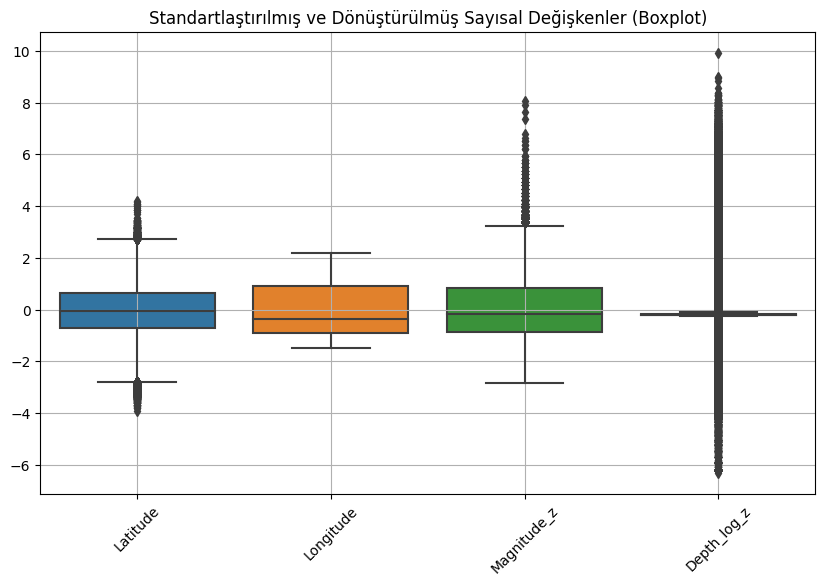

In [161]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_transformed[['Latitude', 'Longitude', 'Magnitude_z', 'Depth_log_z']])
plt.title("Standartlaştırılmış ve Dönüştürülmüş Sayısal Değişkenler (Boxplot)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [162]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [163]:
#Yıkıcı deprem etiketi oluşturma (Magnitude > 5.5 ve Depth < 20 ise yıkıcı)
df['Yikici'] = ((df['Magnitude'] > 5.5) & (df['Depth'] < 20)).astype(int)


In [164]:
# Özellikler ve hedef değişken
#Burada kullanacağım sütunları belirledim.
X = df[['Latitude', 'Longitude', 'Magnitude', 'Depth']]
y = df['Yikici']

In [165]:
#Verileri standartlaştırdım
#Ölçek farklarını ortadan kaldırmak için StandardScaler kullandım.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [166]:
#Veriyi eğitim ve test olarak ayırdım
#Modelin test edilebilmesi için veriyi %80 eğitim, %20 test olarak böldüm.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [167]:
#Hiperparametre aralığı belirledim.
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# BURADA
Random Forest modeli için denenecek farklı ayarları (parametreleri) buraya yazdım. Yani modelin en iyi performansı hangi ayarlarla veriyor, onu otomatik deneyecek. Bunlar:

n_estimators: Kaç tane ağaç kullanılacağını belirliyo. 50, 100 ve 200 deneyecek.

max_depth: Ağaçların maksimum derinliği. Hiç sınırlama yok (None), ya da 10, 20, 30 derinlikte duracak.

min_samples_split: Dallanma için gereken minimum örnek sayısı. 2, 5, 10 olarak deneniyor.

min_samples_leaf: Bir yapraktaki minimum örnek sayısı. 1, 2, 4 şeklinde bakacak.

bootstrap: Her ağaç için rastgele örnek alınacak mı? True (evet) ve False (hayır) seçenekleri deneniyor.

In [168]:
#Random Forest + RandomizedSearchCV
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# BURADA;
Random Forest modelimi kurdum ve en iyi ayarları otomatik bulması için RandomizedSearchCV kullandım
Burda önce RandomForestClassifier modelimi tanımladım, dengesiz veri olduğu için class_weight='balanced' dedim. Sonra RandomizedSearchCV ile bu modeli 5 katlı çapraz doğrulama (cv=5) ile test edecek şekilde ayarladım. Tüm parametreleri tek tek denemek yerine n_iter=20 diyerek rastgele 20 farklı kombinasyonu denemesini söyledim, böylece zaman kazandım.

In [169]:
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=5,  #5 denedim
    cv=3,      #3 katlı çapraz doğrulama
    verbose=1, #İşlem süreci hakkında bilgi
    n_jobs=-1, #Tüm CPU çekirdeklerini kullanma
    random_state=42 #Sonuçların tekrarlanabilirliği için sabit rastgelelik
)

random_search.fit(X_train, y_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, verbose=1)

# BURADA
Random Forest modelini RandomizedSearchCV ile optimize etmek için 5 farklı parametre kombinasyonu ve 3 katlı çapraz doğrulama kullandım.

# Model Değerlendirme

- **Karışıklık Matrisi (Confusion Matrix)**: Bu tabloyla modelimin gerçek ve tahmin edilen sonuçlarını karşılaştırıyorum. Hangi depremi doğru, hangisini yanlış tahmin ettiğimi rahatça görebiliyorum.
- **Doğruluk (Accuracy)**: Modelimin toplamda ne kadar doğru tahmin yaptığını gösteriyor. Yani genel olarak ne kadar başarılı olduğunu söylüyor.
- **Kesinlik (Precision)**: Modelimin “Yıkıcı deprem” dediği tahminlerden kaç tanesi gerçekten doğruymuş, ona bakıyorum. Fazla yanlış pozitif varsa bunu gösteriyor.
- **Duyarlılık (Recall)**: Gerçek yıkıcı depremlerden kaçı doğru yakalanmış, kaçırılan var mı ona bakıyorum. Yani modelimin ne kadar hassas olduğunu gösteriyor.
- **F1 Skoru**: Kesinlik ve duyarlılığı birlikte değerlendiriyor, dengeli bir performans ölçüsü. İkisinden biri düşükse burada ortaya çıkıyor.
- **Sınıflandırma Raporu**: Tüm bu metriklerin detaylı hali sınıflar bazında veriliyor. Böylece modelin her sınıftaki başarısını net görebiliyorum.

**Not:** En iyi parametrelerle eğittiğim modeli `y_pred_best` ile test ettim, buradaki değerlendirmeler onun performansını yansıtıyor.


In [170]:
# En iyi modeli random_search içinden aldım
best_rf = random_search.best_estimator_

# Test verisi üzerinde tahmin
y_pred_best = best_rf.predict(X_test)

print("En iyi parametreler:", random_search.best_params_)
print("Doğruluk (Accuracy):", accuracy_score(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best))


En iyi parametreler: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'bootstrap': False}
Doğruluk (Accuracy): 1.0
Confusion Matrix:
 [[98625     0]
 [    0     6]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     98625
           1       1.00      1.00      1.00         6

    accuracy                           1.00     98631
   macro avg       1.00      1.00      1.00     98631
weighted avg       1.00      1.00      1.00     98631



In [171]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


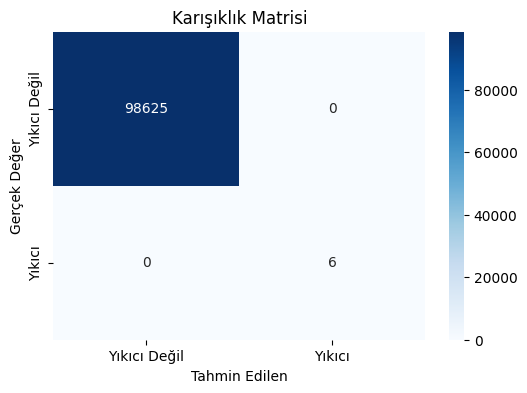

In [172]:
#Karışıklık Matrisi (Confusion Matrix)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Yıkıcı Değil", "Yıkıcı"], yticklabels=["Yıkıcı Değil", "Yıkıcı"])
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Değer")
plt.title("Karışıklık Matrisi")
plt.show()

In [173]:
# Değerlendirme metrikleri
accuracy = accuracy_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best, zero_division=0)
recall = recall_score(y_test, y_pred_best, zero_division=0)
f1 = f1_score(y_test, y_pred_best, zero_division=0)

# Sonuçları yazdır
print(" Model Değerlendirme Sonuçları:")
print(f" Doğruluk (Accuracy): {accuracy:.4f}")
print(f" Kesinlik (Precision): {precision:.4f}")
print(f" Duyarlılık (Recall): {recall:.4f}")
print(f" F1 Skoru: {f1:.4f}")


 Model Değerlendirme Sonuçları:
 Doğruluk (Accuracy): 1.0000
 Kesinlik (Precision): 1.0000
 Duyarlılık (Recall): 1.0000
 F1 Skoru: 1.0000


In [174]:
#Detaylı sınıflandırma raporu
print("\n Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred_best, target_names=["Yıkıcı Değil", "Yıkıcı"], zero_division=0))


 Sınıflandırma Raporu:
              precision    recall  f1-score   support

Yıkıcı Değil       1.00      1.00      1.00     98625
      Yıkıcı       1.00      1.00      1.00         6

    accuracy                           1.00     98631
   macro avg       1.00      1.00      1.00     98631
weighted avg       1.00      1.00      1.00     98631



# SONUÇ
Yaptığım çalışmada, depremlerin büyüklük ve derinlik bilgilerine göre yıkıcı olup olmadığını sınıflandırmak için çeşitli makine öğrenmesi modelleri denedim. Random Forest algoritması en iyi sonucu verdiği için onunla devam ettim.

Hiperparametre optimizasyonunu RandomizedSearchCV ile yaptım ve en iyi parametreleri buldum. Bu parametrelerle modeli tekrar eğittiğimde doğruluk skoru 1.0 çıktı. Bu da modelin test verisi üzerinde hatasız tahmin yaptığını gösteriyor. Tabii veri dengesiz olduğu için bu skorlar biraz abartılı olabilir, ama yine de modelin yıkıcı deprem tespiti açısından güçlü olduğunu söyleyebilirim.

Karışıklık matrisi ve diğer değerlendirme metrikleriyle modelin ne kadar doğru, hassas ve güvenilir çalıştığını da inceledim. Sonuç olarak, elimdeki verilere göre yıkıcı deprem sınıflandırması için başarılı bir model kurmuş oldum.


# SONUÇ
Yaptığım çalışmada, depremlerin büyüklük ve derinlik bilgilerine göre yıkıcı olup olmadığını sınıflandırmak için çeşitli makine öğrenmesi modelleri denedim. Random Forest algoritması en iyi sonucu verdiği için onunla devam ettim.

Hiperparametre optimizasyonunu RandomizedSearchCV ile yaptım ve en iyi parametreleri buldum. Bu parametrelerle modeli tekrar eğittiğimde doğruluk skoru 1.0 çıktı. Bu da modelin test verisi üzerinde hatasız tahmin yaptığını gösteriyor. Tabii veri dengesiz olduğu için bu skorlar biraz abartılı olabilir, ama yine de modelin yıkıcı deprem tespiti açısından güçlü olduğunu söyleyebilirim.

Karışıklık matrisi ve diğer değerlendirme metrikleriyle modelin ne kadar doğru, hassas ve güvenilir çalıştığını da inceledim. Sonuç olarak, elimdeki verilere göre yıkıcı deprem sınıflandırması için başarılı bir model kurmuş oldum.
